In [1]:
import os
import logging
import numpy as np
import healpy as hp
import datetime
import matplotlib.pyplot as plt
import yaml
from glob import glob
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from lenstools import ConvergenceMap
from lenstools.image.noise import GaussianNoiseGenerator

from src.utils import CosmologySettings, extract_seed_from_path
from nbodykit.lab import BigFileCatalog

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
maindir = "/lustre/work/akira.tokiwa/Projects/LensingSSC/"

In [3]:
config_file = os.path.join(maindir, "configs", 'config_analysis.yaml')

# Initialize empty config
config = {}

# Load configuration from YAML if provided and exists
with open(config_file, 'r') as file:
    try:
        config = yaml.safe_load(file)  # Load the configuration from YAML
    except yaml.YAMLError as exc:
        print("Warning: The config file is empty or invalid. Proceeding with default parameters.")
        print(exc)

In [4]:
data_dir = "/lustre/work/akira.tokiwa/Projects/LensingSSC/data/"

cosmo = CosmologySettings(h=0.6774, om=0.309).get_cosmology()
nside = config["nside"]
npix =  hp.nside2npix(nside)
sboxsize = 625
bboxsize = 3750

vmin, vmax = -0.06, 0.06

patch_size = config["patch_size"]
xsize = config["xsize"]
reso = patch_size*60/xsize
nbin = config["nbin"]
lmin, lmax = config["lmin"], config["lmax"]
lmin_size, lmax_size = np.pi / np.deg2rad(patch_size), np.pi / np.deg2rad(reso / 60)

sl = config["scale_angle"]
ngal = config["ngal"]

bins = np.linspace(-4, 4, nbin+1, endpoint=True)
l_edges = np.linspace(lmin, lmax, nbin+1, endpoint=True)

ell = (l_edges[1:] + l_edges[:-1]) / 2
nu = (bins[1:] + bins[:-1]) / 2

In [5]:
zs = 2.0

# Settings

In [15]:
from matplotlib.patches import Arc
from astropy import cosmology

In [14]:
def plot_setting(save_dir, sboxsize, bboxsize, patch_size):
    # Parameters
    replications = bboxsize // sboxsize

    # Convert opening angle to radians
    opening_angle_rad = np.deg2rad(patch_size)

    # Calculate the extent of the light cone in x and y directions
    extent = bboxsize * np.tan(opening_angle_rad)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(7, 4))

    # Draw the replicated boxes
    for i in range(replications):
        ax.vlines(x=i * sboxsize, ymin=-bboxsize / 2, ymax=bboxsize / 2, color='tab:blue', linestyle='--')

    for i in range(4):
        ax.hlines(y=(i+0.5) * sboxsize, xmin=0, xmax=bboxsize, color='tab:blue', linestyle='--')
        ax.hlines(y=-(i+0.5) * sboxsize, xmin=0, xmax=bboxsize, color='tab:blue', linestyle='--')

    for i in range(replications):
        for j in range(4):
            rect = plt.Rectangle((i * sboxsize, -sboxsize/2 + j * sboxsize), sboxsize, sboxsize, edgecolor='blue', linestyle='-', fill=True, alpha=0.1)
            ax.add_patch(rect)
            if j != 0:
                rect = plt.Rectangle((i * sboxsize, -sboxsize/2 - j * sboxsize), sboxsize, sboxsize, edgecolor='blue', linestyle='-', fill=True, alpha=0.1)
                ax.add_patch(rect)

    rect = plt.Rectangle((3 * sboxsize, -sboxsize/2), sboxsize, sboxsize, edgecolor='blue', linestyle='-', fill=True, alpha=0.5)
    ax.add_patch(rect)
    ax.text(3 * sboxsize + sboxsize/2, 0, ' small\n box', fontsize=14, color='black', ha='center', va='center')
        
    # Draw the light cone
    x_coords = [0, bboxsize]
    y_coords = [0, extent]
    ax.plot(x_coords, y_coords, color='tab:red')

    x_coords = [0, bboxsize]
    y_coords = [0, -extent]
    ax.plot(x_coords, y_coords, color='tab:red')

    # Add the opening angle arc
    arc = Arc((0, 0), width=bboxsize*1.9, height=1.9*bboxsize, angle=0,
            theta1=-patch_size, theta2=patch_size, color='tab:green')
    ax.add_patch(arc)

    # Add the opening angle annotation
    arc_radius = bboxsize*0.95
    arc_x = arc_radius * np.cos(opening_angle_rad / 2)
    arc_y = arc_radius * np.sin(opening_angle_rad / 2)
    ax.annotate(f'{patch_size}°',
                xy=(arc_x, arc_y),
                xytext=(arc_x - 900, arc_y - 0),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=18,
                color='black')

    # Set limits and labels
    ax.set_xlim(0, bboxsize)
    ax.set_ylim(-bboxsize / 4, bboxsize / 4)
    ax.set_xlabel('Distance (Mpc/h)', fontsize=14)
    ax.set_ylabel('Distance (Mpc/h)', fontsize=14)
    #ax.set_title('Concept Figure of a Light Cone Configuration')


    # Create a secondary x-axis for redshift
    secax = ax.secondary_xaxis('top')
    secax.set_xlabel('Redshift', fontsize=14)
    redshift_ticks = [0.5, 1.0, 2.0, 3.0]
    distance_ticks = [cosmo.comoving_distance(z).value * cosmo.h for z in redshift_ticks]
    secax.set_xticks(distance_ticks)
    secax.set_xticklabels(redshift_ticks)

    # save the figure
    plt.savefig(f'{save_dir}/light_cone_configuration.png', bbox_inches='tight')

In [16]:
# Define the function
def lens_efficiency(chi, cosmo, zs):
    """Compute the weight function for weak lensing convergence."""
    chis = cosmo.comoving_distance(zs).value  # Mpc
    z = cosmology.z_at_value(cosmo.comoving_distance, chi * u.Mpc).value
    dchi = (1 - chi / chis).clip(0)
    return (1 + z) * chi * dchi  # 1/Mpc

def lensarray(cosmo, zs, bins=50):
    # Create a range of chi values
    chi_values = np.linspace(0.1, cosmo.comoving_distance(zs).value, bins)
    lens_efficiencies = lens_efficiency(chi_values, cosmo, zs)
    lens_efficiencies = lens_efficiencies / np.max(lens_efficiencies)
    return chi_values*cosmo.h, lens_efficiencies

def plot_lenseff(save_dir, zs_list=[0.5, 1.0, 2.0, 3.0]):
    fig, ax = plt.subplots(figsize=(7, 4))

    for zs in zs_list:
        chi_values, lens_efficiency_normalized = lensarray(cosmo, zs)
        ax.plot(chi_values, lens_efficiency_normalized, label=f'z={zs}')

    ax.set_xlabel('Comoving Distance (Mpc/h)')
    ax.set_ylabel('Normalized Lens Efficiency')
    ax.set_title('Countribution of different redshifts to lensing')
    ax.legend()

    # Create a secondary x-axis for redshift
    secax = ax.secondary_xaxis('top')
    secax.set_xlabel('z')
    distance_ticks = [cosmo.comoving_distance(z).value * cosmo.h for z in zs_list]
    secax.set_xticks(distance_ticks)
    secax.set_xticklabels(zs_list)

    ax.grid(True)

    # save the figure
    plt.savefig(f'{save_dir}/lensefficiency.png', bbox_inches='tight')

# load Mass sheet

In [9]:
def load_delta(path):
    sample = np.load(path)
    delta = sample['delta']
    chi1, chi2 = sample['chi1'][0], sample['chi2'][0]
    return delta, chi1, chi2

In [15]:
mass_tiled = glob(os.path.join(data_dir, "tiled", "*", "mass_sheets", 'delta-sheet-50.npz'))
mass_bigbox = glob(os.path.join(data_dir, "bigbox", "*", "mass_sheets", 'delta-sheet-50.npz'))

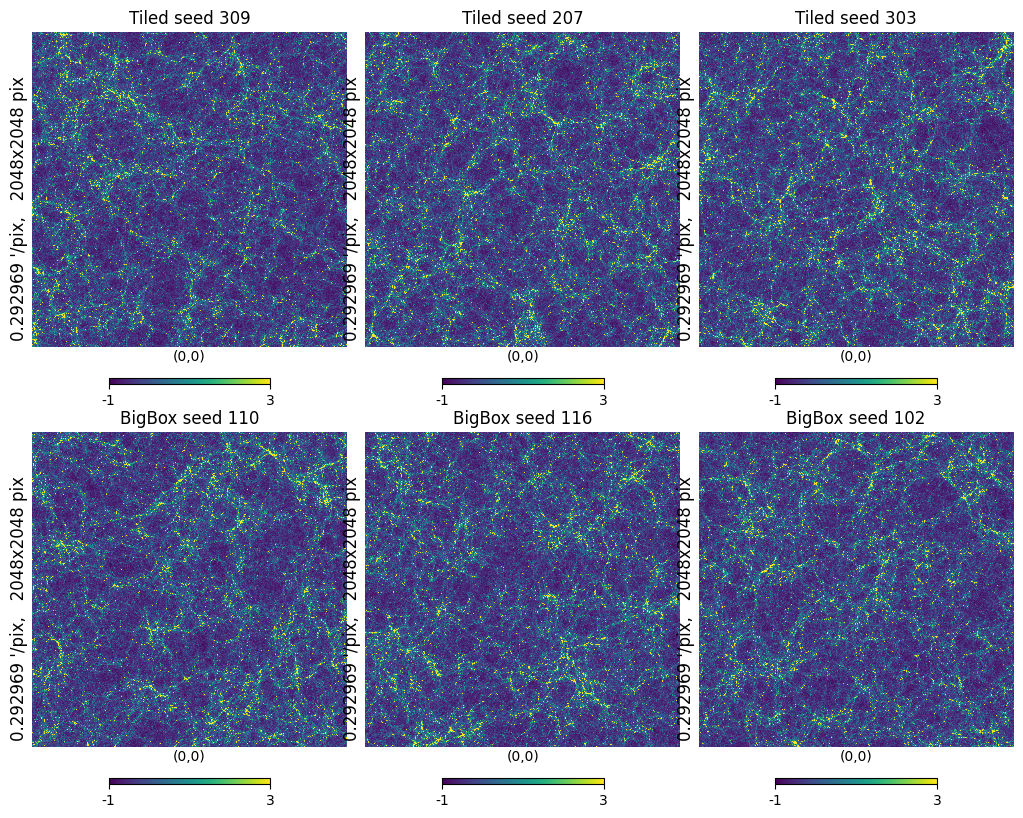

In [18]:
fig = plt.figure(figsize=(10, 8))

for i in range(3):
    mass_file = mass_tiled[i]
    delta, chi1, chi2 = load_delta(mass_file)
    subdir_path = mass_file.split("/")[-3]
    seed_number = extract_seed_from_path(subdir_path)
    title = f"Tiled seed {seed_number}"
    hp.gnomview(delta, rot=[0, 0], reso=reso, xsize=xsize, title=title, sub=(2, 3, i+1), min=-1, max=3, fig=fig, nest=True)

for i in range(3):
    mass_file = mass_bigbox[i]
    delta, chi1, chi2 = load_delta(mass_file)
    subdir_path = mass_file.split("/")[-3]
    seed_number = extract_seed_from_path(subdir_path)
    title = f"BigBox seed {seed_number}"
    hp.gnomview(delta, rot=[0, 0], reso=reso, xsize=xsize, title=title, sub=(2, 3, i+4), min=-1, max=3, fig=fig, nest=True)

plt.show()

# load data

In [22]:
zs = 2.0
kappa_tiled = glob(os.path.join(data_dir, "tiled", "*", "kappa", f'kappa_zs{zs}*.fits'))
kappa_bigbox = glob(os.path.join(data_dir, "bigbox", "*", "kappa", f'kappa_zs{zs}*.fits'))

In [26]:
kappas_tiled = [hp.read_map(kappa_file) for kappa_file in kappa_tiled[:3]]
kappas_bigbox = [hp.read_map(kappa_file) for kappa_file in kappa_bigbox[:3]]

2024-08-29 06:36:07,003 - INFO - NSIDE = 8192
2024-08-29 06:36:07,004 - INFO - ORDERING = RING in fits file
2024-08-29 06:36:07,005 - INFO - INDXSCHM = IMPLICIT
2024-08-29 06:36:14,678 - INFO - NSIDE = 8192
2024-08-29 06:36:14,679 - INFO - ORDERING = RING in fits file
2024-08-29 06:36:14,680 - INFO - INDXSCHM = IMPLICIT
2024-08-29 06:36:22,327 - INFO - NSIDE = 8192
2024-08-29 06:36:22,329 - INFO - ORDERING = RING in fits file
2024-08-29 06:36:22,330 - INFO - INDXSCHM = IMPLICIT
2024-08-29 06:36:32,215 - INFO - NSIDE = 8192
2024-08-29 06:36:32,216 - INFO - ORDERING = RING in fits file
2024-08-29 06:36:32,217 - INFO - INDXSCHM = IMPLICIT
2024-08-29 06:36:41,614 - INFO - NSIDE = 8192
2024-08-29 06:36:41,615 - INFO - ORDERING = RING in fits file
2024-08-29 06:36:41,616 - INFO - INDXSCHM = IMPLICIT
2024-08-29 06:36:51,836 - INFO - NSIDE = 8192
2024-08-29 06:36:51,837 - INFO - ORDERING = RING in fits file
2024-08-29 06:36:51,838 - INFO - INDXSCHM = IMPLICIT


In [27]:
seeds_tiled = [extract_seed_from_path(kappa_file) for kappa_file in kappa_tiled[:3]]
seeds_bigbox = [extract_seed_from_path(kappa_file) for kappa_file in kappa_bigbox[:3]]

In [28]:
fig = plt.figure(figsize=(10, 8))

for i in range(3):
    title = f"Tiled seed {seeds_tiled[i]} zs = {zs}"
    hp.orthview(kappas_tiled[i], fig=fig.number, title=title, sub=(2, 3, i+1), nest=True, cmap="jet", min=vmin, max=vmax, half_sky=True)

for i in range(3):
    title = f"BigBox seed {seeds_bigbox[i]} zs = {zs}"
    hp.orthview(kappas_bigbox[i], fig=fig.number, title=title, sub=(2, 3, i+4), nest=True, cmap="jet", min=vmin, max=vmax, half_sky=True)

# Patch Sky

In [29]:
center = [30, 0]

patches_tiled = [hp.gnomview(kappa, rot=center, reso=reso, xsize=xsize, return_projected_map=True, no_plot=True, nest=True) for kappa in kappas_tiled]
patches_bigbox = [hp.gnomview(kappa, rot=center, reso=reso, xsize=xsize, return_projected_map=True, no_plot=True, nest=True) for kappa in kappas_bigbox]

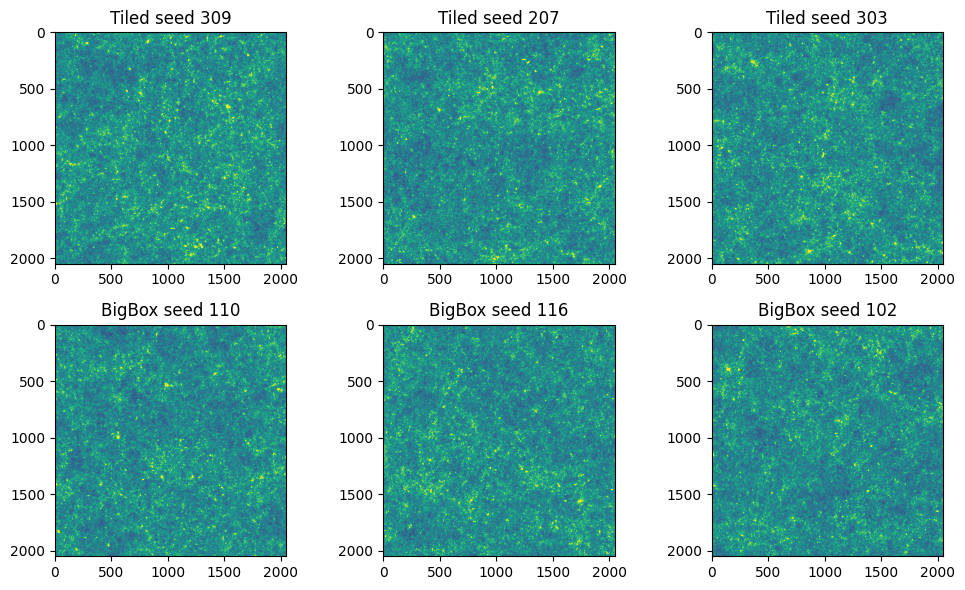

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
titles = ["Tiled" + f" seed {seed}" for seed in seeds_tiled] + ["BigBox" + f" seed {seed}" for seed in seeds_bigbox]
images = [patch_tiled for patch_tiled in patches_tiled] + [patch_bigbox for patch_bigbox in patches_bigbox]

for ax, title, img in zip(axes.flatten(), titles, images):
    ax.imshow(img, vmin=vmin*2, vmax=vmax*2)
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [31]:
convs = []
for image in images:
    conv = ConvergenceMap(image, angle=patch_size*u.deg)
    convs.append(conv)

In [32]:
class ShapeNoiseGenerator():
    def __init__(self, xsize, reso, ngal):
        self.xsize = xsize
        self.reso = reso
        self.ngal = ngal

    def generate(self, seed=np.random.randint(0, 1000)):
        np.random.seed(seed)
        sigma = 0.3 / (reso * np.sqrt(self.ngal))
        noise_map = np.random.normal(loc=0, scale=sigma, size=(self.xsize, self.xsize))
        return noise_map
    
def addNoise_smooth(patch_pixels, noise_map, patch_size=patch_size, scale_angle=2):
    convergence_map = ConvergenceMap(patch_pixels+noise_map, angle=patch_size * u.deg)
    convergence_map.smooth(scale_angle * u.arcmin, inplace=True)
    return convergence_map

In [33]:
noise_generator = ShapeNoiseGenerator(xsize, reso, ngal=30)

In [34]:
conv_ns = []
for conv in convs:
    noise_map = noise_generator.generate()
    conv_ns.append(addNoise_smooth(conv.data.data, noise_map, patch_size=patch_size, scale_angle=2))

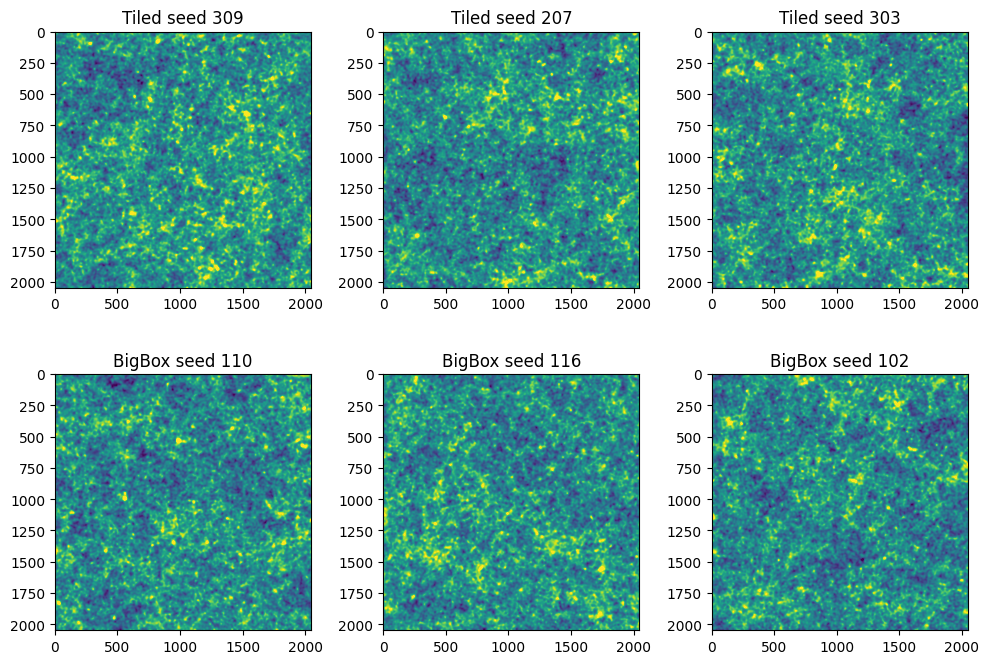

In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
images = [conv.data.data for conv in conv_ns]

for ax, title, img in zip(axes.flatten(), titles, images):
    ax.imshow(img, vmin=vmin, vmax=vmax)
    ax.set_title(title)

plt.tight_layout()
plt.show()

# power Spectrum

In [38]:
hf = np.load(f"/lustre/work/akira.tokiwa/Projects/LensingSSC/results/halofit/kappa_zs{zs}_Clkk_ell_0_3000.npz")
ell_hf, cl_hf = hf['ell'][lmin-1:], hf['clkk'][lmin-1:]

In [ ]:
ell_idx = np.digitize(ell_hf, l_edges, right=True)
cl_hf = np.bincount(ell_idx, weights=cl_hf)
ell_bincount = np.bincount(ell_idx)
cl_hf = (cl_hf/ell_bincount)[1:]

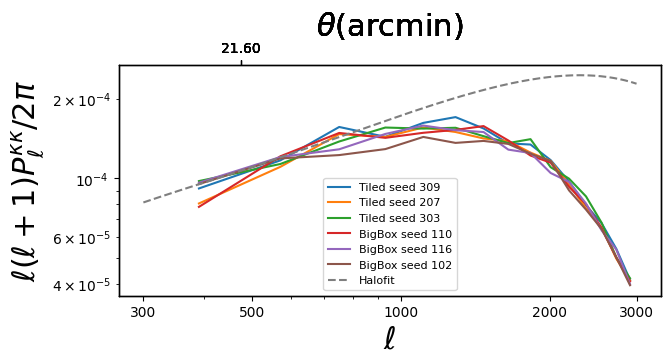

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
for conv, color, label in zip(conv_ns, colors, titles):
    conv.plotPowerSpectrum(l_edges, fig=fig, ax=ax, color=color, label=label)

ax.plot(ell_hf, ell_hf * (ell_hf+1) * cl_hf / (2*np.pi), label="Halofit", color="tab:gray", linestyle="--")

ax.set_xticks([300, 500, 1000, 2000, 3000])
ax.set_xticklabels([300, 500, 1000, 2000, 3000])

ax.legend(fontsize=8)
plt.show()

In [40]:
cls = []
for conv in conv_ns:
    ell, cl = conv.powerSpectrum(l_edges)
    cls.append(cl)

cl = np.vstack(cls)
corr = np.corrcoef(cl, rowvar=False)
cov = np.cov(cl, rowvar=False)

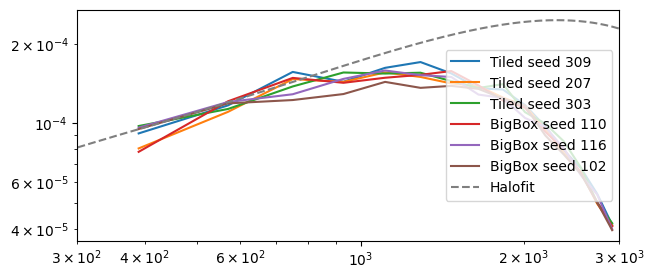

In [42]:
fig = plt.figure(figsize=(7, 3))

for i, cl_tmp in enumerate(cl):
    plt.plot(ell, ell * (ell+1) * cl_tmp/ (2*np.pi), label=titles[i])

plt.plot(ell_hf, ell_hf * (ell_hf+1) * cl_hf / (2*np.pi), label="Halofit", color="tab:gray", linestyle="--")
plt.xscale("log")
plt.yscale("log")
plt.xlim(lmin, lmax)
#plt.ylim(1e-4, 1e-3)
plt.legend()
plt.show()

# Peaks

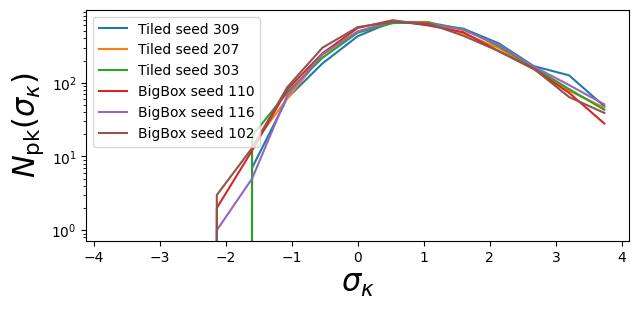

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))

for conv, color, label in zip(conv_ns, colors, titles):
    conv.peakHistogram(bins, norm=True,fig=fig, ax=ax, color=color, label=label)

ax.legend()
plt.show()

In [44]:
def exclude_edges(heights, positions, patch_size_deg, xsize, return_index=True):
    tmp_positions = positions.value * xsize / patch_size_deg
    mask = (tmp_positions[:, 0] > 0) & (tmp_positions[:, 0] < xsize-1) & (tmp_positions[:, 1] > 0) & (tmp_positions[:, 1] < xsize-1)
    if return_index:
        return heights[mask], tmp_positions[mask].astype(int)
    else:
        return heights[mask], positions[mask]
    
def get_peaks(conv, bins, patch_size, xsize):
    heights, positions = conv.locatePeaks(bins, norm=True)
    heights, positions = exclude_edges(heights, positions, patch_size, xsize)
    return np.histogram(heights, bins=bins)[0]

In [45]:
peaks = []
for conv in conv_ns:
    peaks.append(get_peaks(conv, bins, patch_size, xsize))

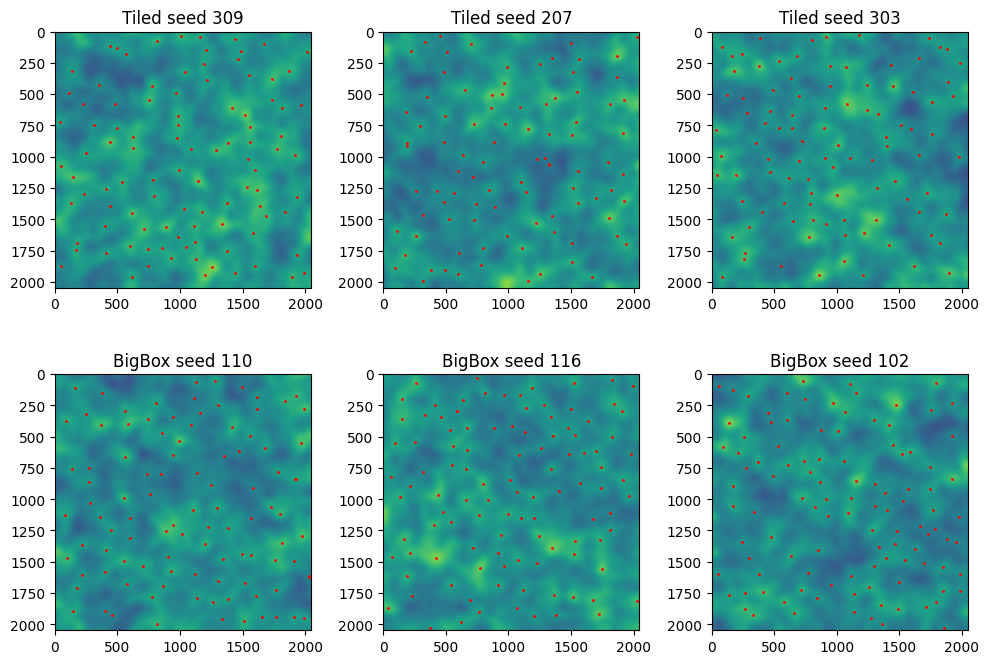

In [46]:

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for ax, title, conv in zip(axes.flatten(), titles, conv_ns):
    heights, positions = conv.smooth(10*u.arcmin).locatePeaks(bins, norm=True)
    heights, positions = exclude_edges(heights, positions, patch_size, xsize)
    ax.imshow(conv.smooth(10*u.arcmin).data, vmin=vmin, vmax=vmax)

    ax.scatter(positions[:, 0], positions[:, 1], c="r", s=1)
    ax.set_title(title)

plt.tight_layout()
plt.show()

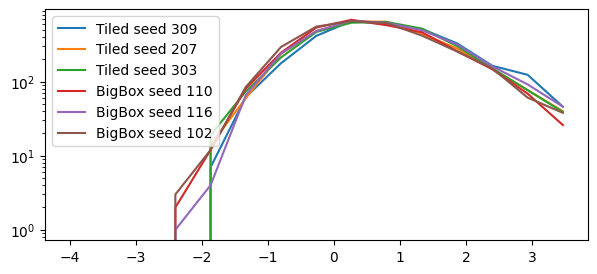

In [47]:
fig = plt.figure(figsize=(7, 3))
for peak, title in zip(peaks, titles):
    plt.plot(bins[:-1], peak, label=title)
plt.legend()
plt.yscale("log")
plt.show()

## PDF

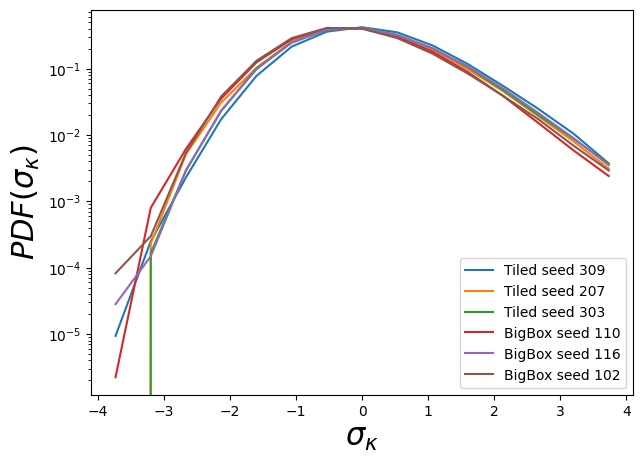

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

for conv, color, label in zip(conv_ns, colors, titles):
    conv.plotPDF(bins, norm=True,fig=fig, ax=ax, color=color, label=label)

ax.set_yscale("log")
ax.legend()
plt.show()

In [49]:
pdfs = []
for conv in conv_ns:
    pdfs.append(conv.pdf(bins, norm=True)[1])

In [50]:
fig = plt.figure(figsize=(7, 3))
for pdf, title in zip(pdfs, titles):
    plt.plot(nu, pdf, label=title)
    
plt.xlabel('SNR')
plt.ylabel('PDF')
plt.yscale('log')
plt.legend()

## bispectrum

In [54]:
bssqs = []
for conv in conv_ns:
    bssqs.append(conv.bispectrum(l_edges, configuration='folded', ratio=0.1)[1])

In [55]:
fig = plt.figure(figsize=(7, 3))

for bssq, title in zip(bssqs, titles):
    plt.plot(ell, np.abs(bssq) * ell**4 / (2*np.pi)**2, label=title)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^4|B_{\ell}|/(2\pi)^2$')
plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()

# Full data matrix

In [6]:
def normalize_peak(peak):
    return (peak.T/np.sum(peak, axis=1)).T

def dimensionless_cl(cl, ell):
    return ell * (ell+1) * cl / (2*np.pi)

def dimiensionless_bispectrum(bispec, ell):
    return bispec * ell**4 / (2*np.pi)**2

In [9]:
data_tiled = glob(os.path.join(data_dir, "tiled", "*", "flat", f"*zs{zs}*_noiseless.npy"))
data_bigbox = glob(os.path.join(data_dir, "bigbox", "*", "flat", f"*zs{zs}*_noiseless.npy"))

In [12]:
def stacking_analysis(data_paths):
    data = np.vstack([np.load(data_path) for data_path in data_paths])
    sq, clkk, pdf, peak, minima = np.split(data, 5, axis=1)
    sq = dimiensionless_bispectrum(sq, ell)
    clkk = dimensionless_cl(clkk, ell)
    peak = normalize_peak(peak)
    minima = normalize_peak(minima)
    data = np.hstack([sq, clkk, pdf, peak, minima])

    patch_per_realizations = data.shape[0] // len(data_paths)
    diag= [np.diag(np.cov(data[i*patch_per_realizations: (i+1)*patch_per_realizations, :], rowvar=False)) for i in range(len(data_paths))]
    diags_std = np.std(data, axis=0)

    diags = np.diag(np.cov(data, rowvar=False))
    corr = np.corrcoef(data, rowvar=False)
    stds = np.std(data, axis=0)
    means = np.mean(data, axis=0)

    return means, stds, diags, corr, diags_std

In [13]:
means_tiled, stds_tiled, diags_tiled, corr_tiled, diags_std_tiled = stacking_analysis(data_tiled)
means_bigbox, stds_bigbox, diags_bigbox, corr_bigbox, diags_std_bigbox = stacking_analysis(data_bigbox)

/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [14]:
corr_ell_tiled, corr_nu_tiled = corr_tiled[:nbin*2, :nbin*2], corr_tiled[nbin*2:, nbin*2:]
corr_ell_bigbox, corr_nu_bigbox = corr_bigbox[:nbin*2, :nbin*2], corr_bigbox[nbin*2:, nbin*2:]

In [15]:
from src.plot import plot_corr, plot_stats

In [30]:
fname = f"{maindir}/img/comparison/correlation_zs{zs}_oa{patch_size}_sl{sl}_noiseless.png"
title_tiled = f"Tiled Correlation, {len(data_tiled)} realizations"
title_bigbox = f"BigBox Correlation, {len(data_bigbox)} realizations"
labels = [r'$B_{\ell}^\mathrm{sq}$', 
          r'$C^{\kappa\kappa}_{\ell}$', 
          "PDF",
          "Peaks",
          "Minima"]

plot_corr(fname, corr_tiled, corr_bigbox, title_tiled, title_bigbox, labels, vmin=-0.15, vmax=0.15)

In [37]:
for i in range(5):
    print(f"{labels[i]}: {np.nanmean(corr_bigbox[i*nbin:(i+1)*nbin, i*nbin:(i+1)*nbin] - corr_tiled[i*nbin:(i+1)*nbin, i*nbin:(i+1)*nbin]):.4f}")


$B_{\ell}^\mathrm{sq}$: 0.0040
$C^{\kappa\kappa}_{\ell}$: 0.0118
PDF: -0.0079
Peaks: -0.0049
Minima: -0.0048


In [25]:
fname = f"{maindir}/img/comparison/correlation_ell_zs{zs}_oa{patch_size}_sl{sl}_noiseless.png"
title_tiled = f"Tiled ell Correlation, {len(data_tiled)} realizations"
title_bigbox = f"BigBox ell Correlation, {len(data_bigbox)} realizations"
labels = [r'$B_{\ell}^\mathrm{sq}$', 
          r'$C^{\kappa\kappa}_{\ell}$']

plot_corr(fname, corr_tiled[:2*nbin, :2*nbin], corr_bigbox[:2*nbin, :2*nbin], title_tiled, title_bigbox, labels, vmin=-0.15, vmax=0.15)

In [23]:
fname = f"{maindir}/img/comparison/mean_zs{zs}_oa{patch_size}_sl{sl}_noiseless.png"
title = f"Mean of Stacked Statistics, zs = {zs}"
title_tiled = f"Tiled: {len(data_tiled)} realizations, BoxSize: {sboxsize} Mpc/h"
title_bigbox = f"BigBox: {len(data_bigbox)} realizations, BoxSize: {bboxsize} Mpc/h"
labels = [r'$B_{\ell}^\mathrm{sq}$', 
          r'$C^{\kappa\kappa}_{\ell}$', 
          "PDF",
          "Peaks",
          "Minima"]

plot_stats(fname, title, title_tiled, title_bigbox, ell, nu, means_tiled, means_bigbox, labels, stds_tiled, stds_bigbox)

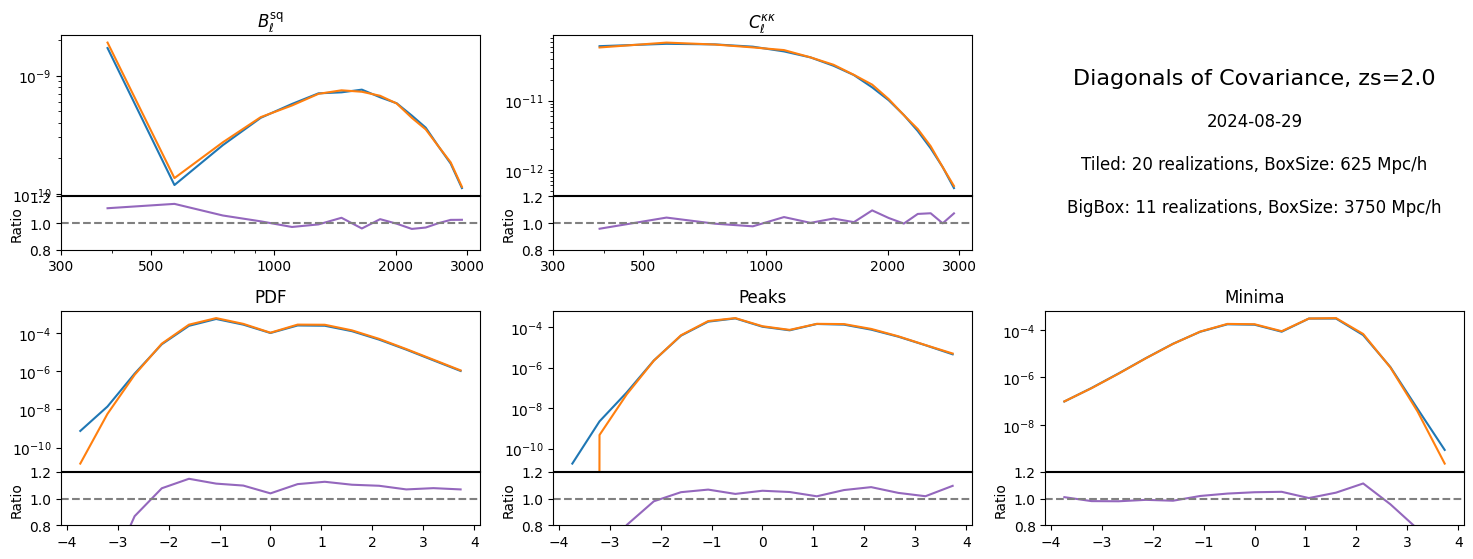

In [24]:
fname = f"{maindir}/img/comparison/diagonal_zs{zs}_oa{patch_size}_sl{sl}_noiseless.png"
title = f"Diagonals of Covariance, zs={zs}"
title_tiled = f"Tiled: {len(data_tiled)} realizations, BoxSize: {sboxsize} Mpc/h"
title_bigbox = f"BigBox: {len(data_bigbox)} realizations, BoxSize: {bboxsize} Mpc/h"
labels = [r'$B_{\ell}^\mathrm{sq}$', 
          r'$C^{\kappa\kappa}_{\ell}$', 
          "PDF",
          "Peaks",
          "Minima"]

plot_stats(fname, title, title_tiled, title_bigbox, ell, nu, diags_tiled, diags_bigbox, labels, ratio_range=[0.8, 1.2])